In [31]:
#IMPORT STATEMENTS

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from torchsummary import summary
import numpy as np
import pandas as pd
import os
import cv2
import torch
import pydicom
from PIL import Image
import matplotlib.image as mpimg
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision.utils import save_image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [32]:
#CUDA INITIALIZATION

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
#APPLYING CLAHE

def apply_clahe_to_folder(input_folder, output_folder, clip_limit=2.0, grid_size=(8, 8)):

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)


    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)


        if os.path.isfile(input_path) and any(ext.lower() in filename.lower() for ext in ['.jpg', '.png', '.jpeg']):

            image = cv2.imread(input_path)

            if len(image.shape) == 3:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
            clahe_image = clahe.apply(image)

            cv2.imwrite(output_path, clahe_image)

In [ ]:

input_folder_path = "data/cnn_clahe/train/NORMAL"
output_folder_path = "data/cnn_clahe/train/NORMAL"

input_folder_path1 = "data/cnn_clahe/train/PNEUMONIA"
output_folder_path1 = "data/cnn_clahe/train/PNEUMONIA"


apply_clahe_to_folder(input_folder_path, output_folder_path)
print(f"CLAHE applied to {input_folder_path} and saved to {output_folder_path}")
apply_clahe_to_folder(input_folder_path1, output_folder_path1)
print(f"CLAHE applied to {input_folder_path1} and saved to {output_folder_path1}")

input_folder_path = "data/cnn_clahe/test/NORMAL"
output_folder_path = "data/cnn_clahe/test/NORMAL"

input_folder_path1 = "data/cnn_clahe/test/PNEUMONIA"
output_folder_path1 = "data/cnn_clahe/test/PNEUMONIA"

apply_clahe_to_folder(input_folder_path, output_folder_path)
print(f"CLAHE applied to {input_folder_path} and saved to {output_folder_path}")
apply_clahe_to_folder(input_folder_path1, output_folder_path1)
print(f"CLAHE applied to {input_folder_path1} and saved to {output_folder_path1}")

In [34]:
#CNN ARCHITECTURE AND DATA LOADING

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.dropout = nn.Dropout(p=0.5)

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=80000, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1024, out_features=512)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(root='data/cnn_clahe/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

cnn_model = CNNModel().to(device)

In [5]:
summary(cnn_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]           2,432
            Conv2d-2         [-1, 32, 224, 224]          25,632
       BatchNorm2d-3         [-1, 32, 224, 224]              64
              ReLU-4         [-1, 32, 224, 224]               0
         MaxPool2d-5         [-1, 32, 112, 112]               0
            Conv2d-6         [-1, 64, 110, 110]          18,496
            Conv2d-7         [-1, 64, 108, 108]          36,928
       BatchNorm2d-8         [-1, 64, 108, 108]             128
              ReLU-9         [-1, 64, 108, 108]               0
        MaxPool2d-10           [-1, 64, 54, 54]               0
           Conv2d-11          [-1, 128, 52, 52]          73,856
           Conv2d-12          [-1, 128, 50, 50]         147,584
      BatchNorm2d-13          [-1, 128, 50, 50]             256
             ReLU-14          [-1, 128,

In [ ]:
#LOSS FUNCTIONS

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

In [ ]:
#TRAINING LOOP FOR CNN MODEL

num_epochs = 15
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    

torch.save(cnn_model.state_dict(), 'models/CNN.pth')
print("CNN Model is saved at 'models/CNN.pth'")


In [17]:
#LOADING CNN MODEL

print("Loading CNN model from 'models/CNN.pth'")
cnn_model.load_state_dict(torch.load('models/CNN.pth'))

Loading CNN model from 'models/CNN.pth'


<All keys matched successfully>

In [21]:
#EXTRACT FEATURES FROM CNN MODEL TO APPLY PCA (DIMENSIONALITY REDUCTION)

def extract_features(loader):
    cnn_features, cnn_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            features = cnn_model(inputs)    
            cnn_features.append(features.cpu().numpy())
            cnn_labels.append(labels.cpu().numpy())

    cnn_features = np.concatenate(cnn_features, axis=0)
    cnn_labels = np.concatenate(cnn_labels, axis=0)
    return cnn_features, cnn_labels

cnn_features, cnn_labels = extract_features(train_loader)
print("Features extracted sucessfully")

Features extracted sucessfully


In [22]:
#APPLYING PCA TO CNN OUTPUT

pca_components = 100 
pca = PCA(n_components=pca_components)
cnn_features_pca = pca.fit_transform(cnn_features)
print("PCA applied sucessfully")

PCA applied sucessfully


In [23]:
#SPLITTING THE DATA INTO TRAINING AND TESTING

x_train, x_test, y_train, y_test = train_test_split(cnn_features_pca, cnn_labels, test_size=0.1, random_state=42)

x_train = torch.from_numpy(x_train).to(device)
x_test = torch.from_numpy(x_test).to(device)
y_train = torch.from_numpy(y_train).to(device).long()
y_test = torch.from_numpy(y_test).to(device).long()

In [35]:
#ELM MODEL ARCHITECTURE 

class ELMModel(nn.Module):
    def __init__(self, input_size=100, hidden_size=500, output_size=2):
        super(ELMModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.input_to_hidden_weights = nn.Parameter(torch.rand(self.input_size, self.hidden_size).to(device))
        self.hidden_biases = nn.Parameter(torch.zeros(1, self.hidden_size).to(device))
        self.hidden_to_output_weights = nn.Parameter(torch.zeros(self.hidden_size, self.output_size).to(device))
        self.output_biases = nn.Parameter(torch.zeros(1, self.output_size).to(device))
        self.activation = nn.ReLU()

    def forward(self, x):

        hidden_output = self.activation(torch.Tensor(x).to(device) @ self.input_to_hidden_weights + self.hidden_biases)
        output = hidden_output @ self.hidden_to_output_weights + self.output_biases
        return output

elm_model = ELMModel(100, 500, 2).to(device)

In [ ]:
#LOSS FUNCTIONS

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(elm_model.parameters(), lr=0.001)

In [ ]:
#TRAINING LOOP FOR ELM

num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = elm_model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    
torch.save(elm_model.state_dict(), 'models/ELM.pth')
print("ELM model is saved at 'models/ELM.pth'")

In [19]:
#LOADING ELM MODEL

print("Loading ELM model from 'models/ELM.pth'")
elm_model.load_state_dict(torch.load('models/ELM.pth'))

Loading ELM model from 'models/ELM.pth'


<All keys matched successfully>

In [24]:
#TESTING THE ELM MODEL

with torch.no_grad():
    elm_model.eval()
    test_outputs = elm_model(x_test)
    _, predicted = torch.max(test_outputs, 1)

In [25]:
#METRICS FOR EVALUATING THE MODEL PERFORMANCE

accuracy = accuracy_score(y_test.cpu().numpy(), predicted.cpu().numpy())
print(f'Accuracy: {accuracy*100:.4f}')

conf_matrix = confusion_matrix(y_test.cpu().numpy(), predicted.cpu().numpy())
print('Confusion Matrix:')
print(conf_matrix)

recall = recall_score(y_test.cpu().numpy(), predicted.cpu().numpy())
print(f'Recall: {recall*100:.4f}')

precision = precision_score(y_test.cpu().numpy(), predicted.cpu().numpy())
print(f'Precision: {precision*100:.4f}')

f1 = f1_score(y_test.cpu().numpy(), predicted.cpu().numpy())
print(f'F1 Score: {f1*100:.4f}')

Accuracy: 98.6590
Confusion Matrix:
[[129   3]
 [  4 386]]
Recall: 98.9744
Precision: 99.2288
F1 Score: 99.1014


In [36]:
labels  = pd.read_csv("rsna/stage_2_train_labels.csv")
labels.fillna(0, inplace=True)
labels = labels[labels['Target'] == 1]
new_df = labels.head(5000)
class_train, class_val = train_test_split(new_df, test_size=0.20, random_state=42)
train_images_dir = "rsna/stage_2_train_images/"

In [37]:
def create_mask(datafm, n_classes=2, device="cpu"):
    IMAGE_SIZE = 1024
    ADJUSTED_IMAGE_SIZE = 224
    FACTOR = ADJUSTED_IMAGE_SIZE / IMAGE_SIZE
    X = []
    y = []
    masks = torch.zeros((len(datafm), ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE), device=device)
    for index, patient_id in enumerate(datafm['patientId']):
        image_path = train_images_dir + patient_id + ".dcm"
        img = pydicom.dcmread(image_path).pixel_array
        img = cv2.resize(img, (ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        X.append(img)
        
        rows = datafm[datafm['patientId'] == patient_id]
        y.append(rows['Target'].values[0])

        row_data = list(rows.T.to_dict().values())
        for row in row_data:
            x1 = int(row['x'] * FACTOR)
            x2 = int((row['x'] * FACTOR) + (row['width'] * FACTOR))
            y1 = int(row['y'] * FACTOR)
            y2 = int((row['y'] * FACTOR) + (row['height'] * FACTOR))
            masks[index, y1:y2, x1:x2] = 1

    X = np.array(X)
    y = np.array(y)
    X = np.expand_dims(X, axis=-1)
    X = np.repeat(X, 3, axis=-1)

    train_masks_input = np.expand_dims(masks, axis=3)
    train_masks_cat = np.array(torch.nn.functional.one_hot(torch.tensor(train_masks_input).long(), n_classes))
    y_train_cat = train_masks_cat.reshape((train_masks_input.shape[0], train_masks_input.shape[1], train_masks_input.shape[2], n_classes))

    return X, y_train_cat

X_train, y_train = create_mask(class_train)
X_val, y_val = create_mask(class_val)
print("Masks created successfully")


Masks created successfully


In [38]:
#SAVING THE MASKS INTO .png FILES

def save(path, data):
    if not os.path.exists(path):
        os.makedirs(path)

    for i in range(len(data)):
        img = Image.fromarray(data[i]) 
        img.save(f"{path}/image_{i}.png")
        
    print(f"Images saved to {path}")

def preprocess_save(path, data):

    if not os.path.exists(path):
        os.makedirs(path)
        
    for i in range(data.shape[0]):  
        segmentation_mask = np.argmax(data[i], axis=-1)  
        black_mask = np.zeros((data.shape[1], data.shape[2]), dtype=np.uint8)
        black_mask[segmentation_mask == 0] = 0
        black_mask[segmentation_mask == 1] = 255
        img = Image.fromarray(black_mask)
        img.save(f'{path}/image_{i}.png')
        
    print(f"Images saved to {path}")


save("data/train_images/", X_train)
preprocess_save("data/train_masks/", y_train)

save("data/val_images/", X_val)
preprocess_save("data/val_masks/", y_val)


Images saved to data/train_images/
Images saved to data/train_masks/
Images saved to data/val_images/
Images saved to data/val_masks/


In [40]:
#DECLARING HYPER PARAMETERS AND TRANSFORMATIONS FOR DATA LOADERS

LEARNING_RATE = 1e-4
BATCH_SIZE = 4
NUM_EPOCHS = 30
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224  
TRAIN_IMG_DIR = "data/train_images/"
TRAIN_MASK_DIR = "data/train_masks/"
VAL_IMG_DIR = "data/val_images/"
VAL_MASK_DIR = "data/val_masks/"

In [41]:

input_folder_path = TRAIN_IMG_DIR
output_folder_path = TRAIN_IMG_DIR

input_folder_path1 = VAL_IMG_DIR
output_folder_path1 = VAL_IMG_DIR


apply_clahe_to_folder(input_folder_path, output_folder_path)
print(f"CLAHE applied to {input_folder_path} and saved to {output_folder_path}")
apply_clahe_to_folder(input_folder_path1, output_folder_path1)
print(f"CLAHE applied to {input_folder_path1} and saved to {output_folder_path1}")

CLAHE applied to data/train_images/ and saved to data/train_images/
CLAHE applied to data/val_images/ and saved to data/val_images/


In [42]:
#UNET ARCHITECTURE

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels*2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels*2, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return torch.sigmoid(self.final_conv(x))

unet_model = UNET(in_channels=3, out_channels=1).to(device)

In [7]:
summary(unet_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 224, 224]           3,456
       BatchNorm2d-2        [-1, 128, 224, 224]             256
              ReLU-3        [-1, 128, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          73,728
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
        DoubleConv-7         [-1, 64, 224, 224]               0
         MaxPool2d-8         [-1, 64, 112, 112]               0
            Conv2d-9        [-1, 256, 112, 112]         147,456
      BatchNorm2d-10        [-1, 256, 112, 112]             512
             ReLU-11        [-1, 256, 112, 112]               0
           Conv2d-12        [-1, 128, 112, 112]         294,912
      BatchNorm2d-13        [-1, 128, 112, 112]             256
             ReLU-14        [-1, 128, 1

In [43]:
#CREATING DATA SET FOR UNET BASED ON PREVIOUSLY SAVED IMAGES

class PneumoniaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask


In [44]:

train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

#CREATING DATSETS AND DATA LOADERS FOR TRAINING AND VALIDATION

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
):
    train_ds = PneumoniaDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
    )

    val_ds = PneumoniaDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

#DATA LOADERS

train_loader, val_loader = get_loaders(
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    VAL_IMG_DIR,
    VAL_MASK_DIR,
    BATCH_SIZE,
    train_transform,
    val_transforms,
)

In [45]:
#METRICS FOR UNET

def calculate_metrics(outputs, targets):
    outputs = outputs > 0.5
    targets = targets > 0.5
    accuracy = accuracy_score(targets.flatten(), outputs.flatten())
    mean_iou = recall_score(targets.flatten(), outputs.flatten())
    return accuracy, mean_iou

def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

class DiceLoss(torch.nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        dice = dice_coefficient(y_true.view(-1), y_pred.view(-1), self.smooth)
        return 1 - dice
dice_loss = DiceLoss()

In [46]:
from tqdm import tqdm

best_avg_accuracy = -1
best_model_state = None

optimizer = torch.optim.NAdam(unet_model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

epochs_num, training_loss, validation_loss, accuracy_scores, mean_iou_scores = [], [], [], [], []

for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    val_loss = 0.0
    
    unet_model.train()
    train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} - Training')
    for batch_idx, (data, target) in enumerate(train_loader_tqdm):
        data, target = data.to(device), target.to(device)
        output = unet_model(data)
        loss = dice_loss(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_loader_tqdm.set_postfix({'loss': loss.item()})

    unet_model.eval() 
    accuracies, mean_ious= [], []
    val_loader_tqdm = tqdm(val_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} - Validation')
    with torch.no_grad():
        for data_val, target_val in val_loader_tqdm:
            data_val, target_val = data_val.to(device), target_val.to(device)
            output_val = unet_model(data_val)
            val_loss += dice_loss(output_val, target_val).item()
            accuracy, mean_iou = calculate_metrics(output_val.cpu().numpy(), target_val.cpu().numpy())
            accuracies.append(accuracy)
            mean_ious.append(mean_iou)
            val_loader_tqdm.set_postfix({'val_loss': val_loss / len(val_loader)})

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    avg_accuracy = np.mean(accuracies)
    avg_ious = np.mean(mean_ious)
        
    epochs_num.append(epoch+1)
    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    accuracy_scores.append(avg_accuracy)
    mean_iou_scores.append(avg_ious)
        
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {avg_accuracy:.4f}, mean_iou: {avg_ious:.4f}')
    
    scheduler.step(avg_accuracy)


    if avg_accuracy > best_avg_accuracy:
        best_avg_accuracy = avg_accuracy

        best_model_state = unet_model.state_dict()

unet_model.load_state_dict(best_model_state)
torch.save(unet_model.state_dict(), 'models/UNET.pth')
print("UNET model is saved at 'models/UNET.pth'")


Epoch 1/30 - Validation: 100%|██████████| 250/250 [01:23<00:00,  2.98it/s, val_loss=0.587]


Epoch 1/30, Training Loss: 0.5466, Validation Loss: 0.5866, Validation Accuracy: 0.8425, mean_iou: 0.7921


Epoch 2/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.10it/s, val_loss=0.541]


Epoch 2/30, Training Loss: 0.4437, Validation Loss: 0.5414, Validation Accuracy: 0.8711, mean_iou: 0.6911


Epoch 3/30 - Validation: 100%|██████████| 250/250 [01:29<00:00,  2.80it/s, val_loss=0.521]


Epoch 3/30, Training Loss: 0.4104, Validation Loss: 0.5207, Validation Accuracy: 0.8675, mean_iou: 0.7484


Epoch 4/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.10it/s, val_loss=0.503]


Epoch 4/30, Training Loss: 0.3972, Validation Loss: 0.5026, Validation Accuracy: 0.8729, mean_iou: 0.7645


Epoch 5/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.10it/s, val_loss=0.505]


Epoch 5/30, Training Loss: 0.3890, Validation Loss: 0.5046, Validation Accuracy: 0.8667, mean_iou: 0.7910


Epoch 6/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.11it/s, val_loss=0.497]


Epoch 6/30, Training Loss: 0.3860, Validation Loss: 0.4968, Validation Accuracy: 0.8889, mean_iou: 0.6785


Epoch 7/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.09it/s, val_loss=0.495]


Epoch 7/30, Training Loss: 0.3798, Validation Loss: 0.4946, Validation Accuracy: 0.8824, mean_iou: 0.7249


Epoch 8/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.09it/s, val_loss=0.492]


Epoch 8/30, Training Loss: 0.3734, Validation Loss: 0.4918, Validation Accuracy: 0.8821, mean_iou: 0.7330


Epoch 9/30 - Validation: 100%|██████████| 250/250 [01:29<00:00,  2.79it/s, val_loss=0.484]


Epoch 9/30, Training Loss: 0.3746, Validation Loss: 0.4841, Validation Accuracy: 0.8861, mean_iou: 0.7297


Epoch 10/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.09it/s, val_loss=0.51] 


Epoch 10/30, Training Loss: 0.3717, Validation Loss: 0.5095, Validation Accuracy: 0.8973, mean_iou: 0.6007


Epoch 11/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.09it/s, val_loss=0.485]


Epoch 11/30, Training Loss: 0.3703, Validation Loss: 0.4853, Validation Accuracy: 0.8867, mean_iou: 0.7258


Epoch 12/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.09it/s, val_loss=0.487]


Epoch 12/30, Training Loss: 0.3671, Validation Loss: 0.4870, Validation Accuracy: 0.8972, mean_iou: 0.6505


Epoch 13/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.09it/s, val_loss=0.486]


Epoch 13/30, Training Loss: 0.3661, Validation Loss: 0.4861, Validation Accuracy: 0.8839, mean_iou: 0.7379


Epoch 14/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.09it/s, val_loss=0.483]


Epoch 14/30, Training Loss: 0.3640, Validation Loss: 0.4830, Validation Accuracy: 0.8884, mean_iou: 0.7176


Epoch 15/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.09it/s, val_loss=0.485]


Epoch 15/30, Training Loss: 0.3631, Validation Loss: 0.4851, Validation Accuracy: 0.8826, mean_iou: 0.7501


Epoch 16/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.10it/s, val_loss=0.481]


Epoch 16/30, Training Loss: 0.3600, Validation Loss: 0.4810, Validation Accuracy: 0.8874, mean_iou: 0.7281
Epoch 00016: reducing learning rate of group 0 to 5.0000e-05.


Epoch 17/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.09it/s, val_loss=0.481]


Epoch 17/30, Training Loss: 0.3536, Validation Loss: 0.4814, Validation Accuracy: 0.8941, mean_iou: 0.6861


Epoch 18/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.10it/s, val_loss=0.477]


Epoch 18/30, Training Loss: 0.3506, Validation Loss: 0.4767, Validation Accuracy: 0.8928, mean_iou: 0.7072


Epoch 19/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.09it/s, val_loss=0.481]


Epoch 19/30, Training Loss: 0.3461, Validation Loss: 0.4808, Validation Accuracy: 0.8912, mean_iou: 0.7041


Epoch 20/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.11it/s, val_loss=0.481]


Epoch 20/30, Training Loss: 0.3480, Validation Loss: 0.4815, Validation Accuracy: 0.8874, mean_iou: 0.7266


Epoch 21/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.11it/s, val_loss=0.486]


Epoch 21/30, Training Loss: 0.3457, Validation Loss: 0.4859, Validation Accuracy: 0.8944, mean_iou: 0.6709


Epoch 22/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.11it/s, val_loss=0.479]


Epoch 22/30, Training Loss: 0.3445, Validation Loss: 0.4786, Validation Accuracy: 0.8906, mean_iou: 0.7142
Epoch 00022: reducing learning rate of group 0 to 2.5000e-05.


Epoch 23/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.09it/s, val_loss=0.48] 


Epoch 23/30, Training Loss: 0.3415, Validation Loss: 0.4804, Validation Accuracy: 0.8904, mean_iou: 0.7081


Epoch 24/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.10it/s, val_loss=0.476]


Epoch 24/30, Training Loss: 0.3387, Validation Loss: 0.4757, Validation Accuracy: 0.8915, mean_iou: 0.7161


Epoch 25/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.11it/s, val_loss=0.479]


Epoch 25/30, Training Loss: 0.3380, Validation Loss: 0.4793, Validation Accuracy: 0.8895, mean_iou: 0.7172


Epoch 26/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.11it/s, val_loss=0.478]


Epoch 26/30, Training Loss: 0.3365, Validation Loss: 0.4779, Validation Accuracy: 0.8870, mean_iou: 0.7391


Epoch 27/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.12it/s, val_loss=0.475]


Epoch 27/30, Training Loss: 0.3360, Validation Loss: 0.4748, Validation Accuracy: 0.8913, mean_iou: 0.7198


Epoch 28/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.11it/s, val_loss=0.477]


Epoch 28/30, Training Loss: 0.3353, Validation Loss: 0.4767, Validation Accuracy: 0.8915, mean_iou: 0.7106
Epoch 00028: reducing learning rate of group 0 to 1.2500e-05.


Epoch 29/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.11it/s, val_loss=0.48] 


Epoch 29/30, Training Loss: 0.3327, Validation Loss: 0.4800, Validation Accuracy: 0.8946, mean_iou: 0.6835


Epoch 30/30 - Validation: 100%|██████████| 250/250 [01:20<00:00,  3.09it/s, val_loss=0.479]


Epoch 30/30, Training Loss: 0.3341, Validation Loss: 0.4791, Validation Accuracy: 0.8957, mean_iou: 0.6793
UNET model is saved at 'models/UNET.pth'


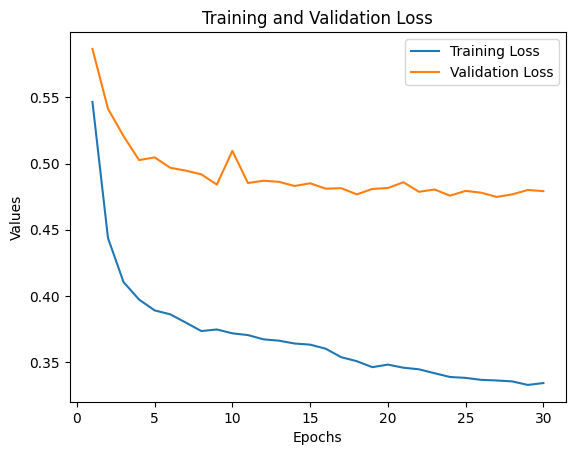

In [47]:
#PLOTTING DATA

plt.plot(epochs_num, training_loss, label='Training Loss')
plt.plot(epochs_num, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


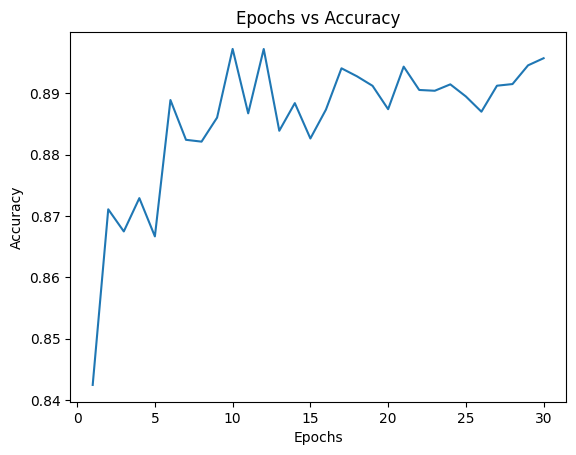

In [48]:
#PLOTTING DATA

plt.plot(epochs_num, accuracy_scores)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epochs vs Accuracy')
plt.show()

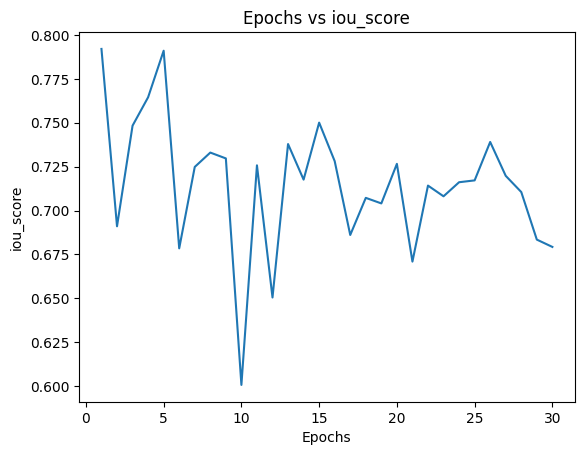

In [49]:
#PLOTTING DATA

plt.plot(epochs_num, mean_iou_scores)
plt.xlabel('Epochs')
plt.ylabel('iou_score')
plt.title('Epochs vs iou_score')
plt.show()

In [50]:
#LOADING UNET MODEL

print("Loading UNET model from 'models/UNET.pth'")
unet_model.load_state_dict(torch.load('models/UNET.pth'))

Loading UNET model from 'models/UNET.pth'


<All keys matched successfully>

In [51]:
#SAVING OUTPUTS AS .png FILES 

def save_tensor_as_image(tensor, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    save_image(tensor, filename)

path ='data/output'
if not os.path.exists(path):
        os.makedirs(path)

output_counter = 0

for data_val, target_val in val_loader:
    data_val, target_val = data_val.to(device), target_val.to(device)
    output_val = unet_model(data_val)
    output_val = (output_val > 0.5).float()
    
    for output in output_val:
        save_tensor_as_image(output, os.path.join(path, f'image_{output_counter}.png'))
        output_counter += 1

print(f"images saved sucessfully to {path}/")


images saved sucessfully to data/output/


The input image has PNEUMONIA


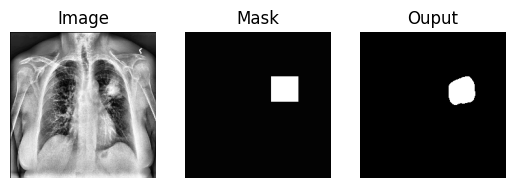

In [54]:
# TESTING A SINGLE IMAGE

def process_image(image_path, image_size, mode, device):
    # CLAHE
    image = cv2.imread(image_path)

    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_image = clahe.apply(image)
    
    # Load and preprocess image
    image = Image.fromarray(clahe_image).convert(mode)
    preprocess = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.0], std=[1.0]),
    ])
    image = preprocess(image)
    image = image.unsqueeze(0)
    image = image.to(device)
    
    return image


image1_path = "data/val_images/image_1.png"
image2_path = "data/val_masks/image_1.png"
image_size = 224
mode = "RGB"  

image1 = process_image(image1_path, image_size, mode, device)


# Load CNN model
cnn_model.load_state_dict(torch.load('models/CNN.pth'))
with torch.no_grad():
    cnn_model.eval()
    features = cnn_model(image1)


# Apply PCA
pca = PCA(n_components=100)
features_np = features.squeeze().cpu().numpy()
features_np = features_np.reshape(-1)
features_pca = features_np[:100]

# Apply ELM
elm_model.load_state_dict(torch.load('models/ELM.pth'))
with torch.no_grad():
    elm_model.eval()
    test_outputs = elm_model(features_pca)
    _, predicted = torch.max(test_outputs, 1)

value = predicted.tolist()[0]

if value == 1:
    print("The input image has PNEUMONIA")
    image1 = process_image(image1_path, (224, 224), 'RGB', device)
    image2 = process_image(image2_path, (224, 224), 'RGB', device)
    unet_model.load_state_dict(torch.load("models/UNET.pth"))
    with torch.no_grad():
        output = unet_model(image1)
        output = (output > 0.5).float()
    numpy_array1 = image1.permute(2, 3, 1, 0).cpu().numpy().squeeze(-1)
    numpy_array2 = image2.permute(2, 3, 1, 0).cpu().numpy().squeeze(-1)
    numpy_array3 = output.permute(2, 3, 1, 0).cpu().numpy().squeeze(-1)

    fig, axes = plt.subplots(1, 3)

    # Plot each image
    axes[0].imshow(numpy_array1)
    axes[0].axis('off')
    axes[0].set_title('Image')

    axes[1].imshow(numpy_array2)
    axes[1].axis('off')
    axes[1].set_title('Mask')
    
    axes[2].imshow(numpy_array3, cmap = "gray")
    axes[2].axis('off')
    axes[2].set_title('Ouput')

    plt.show()
    
else:
    print("The input image has NO PNEUMONIA")
    

In [53]:
import os
import cv2
import numpy as np

def overlay_masks_on_images(image_folder, output_folder, mask_output_folder, mask_folder):
    # Iterate through each image file in the folder
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    for filename in os.listdir(image_folder):
        if filename.endswith('.png'):
            # Load the image and masks
            image = cv2.imread(os.path.join(image_folder, filename))
            mask1 = cv2.imread(os.path.join(mask_output_folder, filename), cv2.IMREAD_GRAYSCALE)
            mask2 = cv2.imread(os.path.join(mask_folder, filename), cv2.IMREAD_GRAYSCALE)

            # Convert the masks to 3-channel images
            mask1_color = cv2.cvtColor(mask1, cv2.COLOR_GRAY2BGR)
            mask2_color = cv2.cvtColor(mask2, cv2.COLOR_GRAY2BGR)

            # Set transparency levels for the masks
            alpha = 0.7  # Transparency level

            # Overlay the masks with different colors onto the image
            mask1_color[np.where((mask1_color == [255, 255, 255]).all(axis=2))] = [0, 0, 255]  # Red color
            mask2_color[np.where((mask2_color == [255, 255, 255]).all(axis=2))] = [0, 255, 0]  # Green color

            # Overlay the colored masks onto the original image with preserved brightness
            overlay = cv2.addWeighted(image, 1, mask1_color, alpha, 0)
            overlay = cv2.addWeighted(overlay, 1, mask2_color, alpha, 0)

            # Save the overlaid image
            cv2.imwrite(os.path.join(output_folder, f'{filename}'), overlay)

# Example usage:
overlay_masks_on_images('data/val_images/', 'data/processed_output/', 'data/output/', 'data/val_masks/')
